# Sprint15課題 ディープラーニングフレームワーク2

## 【問題1】公式Exampleを分担して実行
[Transfer Learning with TFHub](https://www.tensorflow.org/beta/tutorials/images/hub_with_keras)

In [52]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0531 15:58:04.745541 4354127296 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

Dataset

In [53]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 7s 0us/step


In [58]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


In [59]:
for image_batch, label_batch in image_data:
        print("Image batch shape: ", image_batch.shape)
        print("Labe batch shape: ", label_batch.shape)
        break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


ImageNet Classifier

In [60]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [61]:
def classifier(x):
        classifier_module = hub.Module(classifier_url)
        return classifier_module(x)
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [62]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0531 16:05:50.471258 4354127296 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [63]:
#Rebuild the data generator, with the output size set to match what's expected by the module.
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
        print("Image batch shape: ", image_batch.shape)
        print("Labe batch shape: ", label_batch.shape)
        break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [64]:
#When using Keras, TFHub modules need to be manually initialized.
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

65536/61306 [================================] - 0s 0us/step


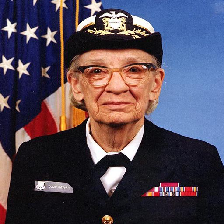

In [65]:
#Download a single image to try the model on.
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [66]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [67]:
#Add a batch dimension, and pass the image to the model.
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [69]:
#The result is a 1001 element vector of logits, rating the probability of each class for the image.
#So the top class ID can be found with argmax:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

Decode the predictions

In [70]:
#We have the predicted class ID, Fetch the ImageNet labels, and decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


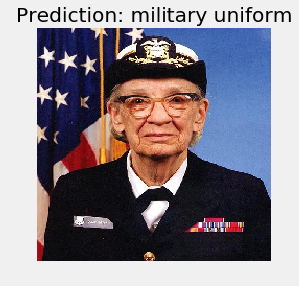

In [72]:
plt.style.use('fivethirtyeight')
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

Run it on a batch of images

In [73]:
# Now run the classifier on the image batch.
result_batch = classifier_model.predict(image_batch)
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['hip', 'daisy', 'fountain', 'ant', 'bakery', 'greenhouse',
       'cardoon', 'conch', 'daisy', 'artichoke', 'sea urchin', 'bee',
       'gyromitra', 'conch', 'daisy', 'croquet ball', 'daisy', 'coil',
       'broccoli', 'picket fence', 'daisy', 'rocking chair',
       'picket fence', 'pot', 'daisy', 'daisy', 'pot', 'daisy', 'corn',
       'cardoon', 'daisy', 'barrow'], dtype='<U30')

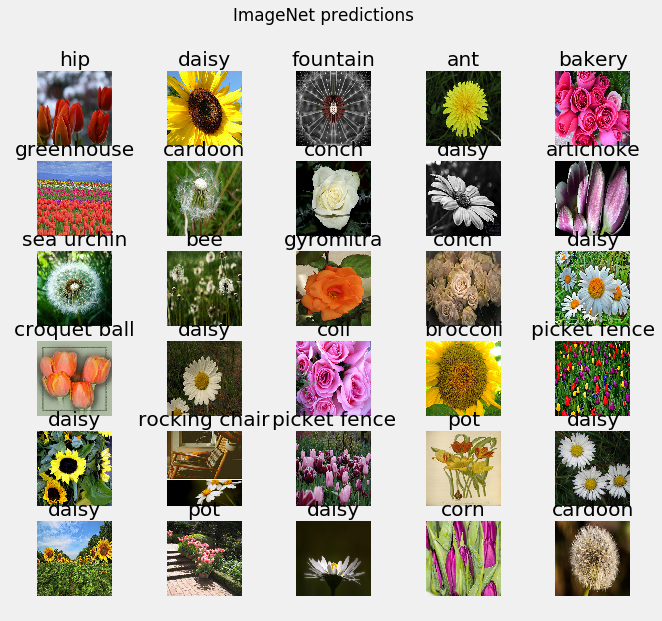

In [74]:
#Now check how these predictions line up with the images:
#See the LICENSE.txt file for image attributions.
#The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

plt.figure(figsize=(10,9))
for n in range(30):
        plt.subplot(6,5, n+1)
        plt.imshow(image_batch[n])
        plt.title(labels_batch[n])
        plt.axis('off')
        _ = plt.suptitle("ImageNet predictions")

Simple transfer learning

In [76]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

In [77]:
#Create the module, and check the expected image size:
def feature_extractor(x):
        feature_extractor_module = hub.Module(feature_extractor_url)
        return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [78]:
#Ensure the data generator is generating images of the expected size:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
        print("Image batch shape: ", image_batch.shape)
        print("Labe batch shape: ", label_batch.shape)
        break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [79]:
#Wrap the module in a keras layer.
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [80]:
#Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.
features_extractor_layer.trainable = False

Attach a classification head

In [81]:
#Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.
model = tf.keras.Sequential([
        features_extractor_layer,
        layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0531 16:24:22.510354 4354127296 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [82]:
#Initialize the TFHub module.
init = tf.global_variables_initializer()
sess.run(init)

In [83]:
#Test run a single batch, to see that the result comes back with the expected sha
result = model.predict(image_batch)
result.shape

(32, 5)

Train the model

In [84]:
#Use compile to configure the training process:
model.compile(
        optimizer=tf.train.AdamOptimizer(), 
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [85]:
#Now use the .fit method to train the model.
#To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch.
class CollectBatchStats(tf.keras.callbacks.Callback):
        def __init__(self):
                self.batch_losses = []
                self.batch_acc = []

        def on_batch_end(self, batch, logs=None):
                self.batch_losses.append(logs['loss'])
                self.batch_acc.append(logs['acc'])

In [86]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

114/114 [==============================] - 168s 1s/step - loss: 0.6564 - acc: 0.7567


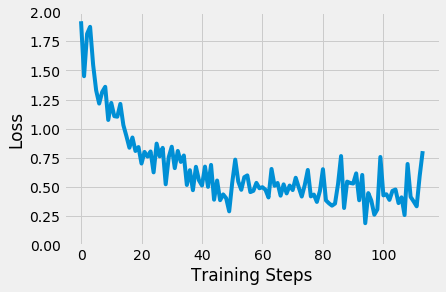

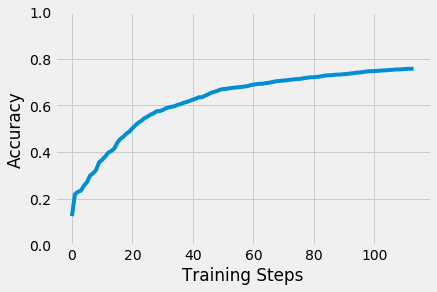

In [87]:
#Now after, even just a few training iterations, we can already see that the model is making progress on the task.
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

Check the predictions

In [88]:
#To redo the plot from before, first get the ordered list of class names:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [90]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Daisy', 'Sunflowers', 'Dandelion', 'Dandelion', 'Daisy',
       'Sunflowers', 'Sunflowers', 'Roses', 'Daisy', 'Sunflowers',
       'Roses', 'Tulips', 'Daisy', 'Roses', 'Roses', 'Daisy',
       'Sunflowers', 'Sunflowers', 'Tulips', 'Dandelion', 'Dandelion',
       'Sunflowers', 'Sunflowers', 'Roses', 'Tulips', 'Roses', 'Tulips',
       'Daisy', 'Roses', 'Tulips', 'Tulips', 'Roses'], dtype='<U10')

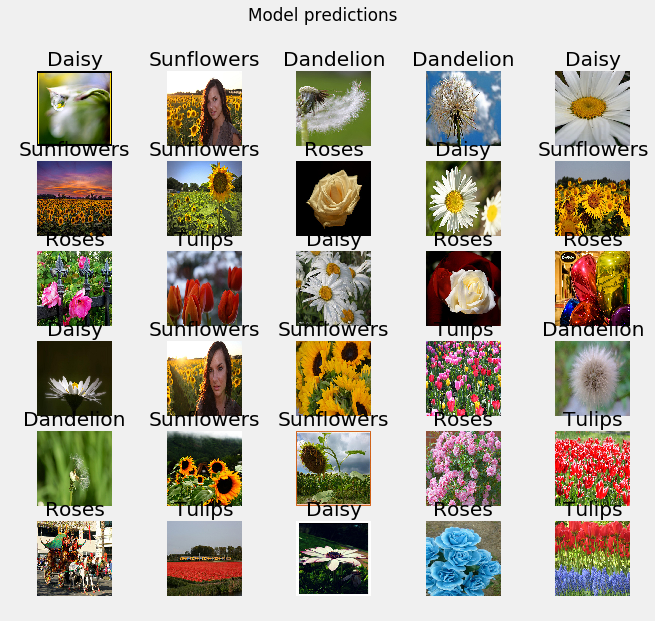

In [91]:
#Plot the result
plt.figure(figsize=(10,9))
for n in range(30):
        plt.subplot(6,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(labels_batch[n])
        plt.axis('off')
        _ = plt.suptitle("Model predictions")

## 【問題2】Iris（2値分類）をKerasで学習

問題3で代替

## 【問題3】Iris（多値分類）をKerasで学習

In [120]:
from sklearn.datasets import load_iris
import numpy as np
iris = load_iris()
X = iris.data
y = iris.target
print(X[:5])
print(y[:5])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]


In [121]:
#one hot encode target data
eye = np.eye(len(np.unique(y)))
y = eye[y]
print(y[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [122]:
from sklearn.model_selection import train_test_split
#all -> train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train -> train, val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [123]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

# ハイパーパラメータの設定
batch_size = 10
n_epochs = 20

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = y.shape[1]

model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input))
model.add(Activation('relu'))
model.add(Dense(n_hidden2, input_dim=n_hidden1))
model.add(Activation('relu'))
model.add(Dense(n_classes, input_dim=n_hidden2))
model.add(Activation('softmax'))
#compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#fit
model.fit(x=X_train, y=y_train, epochs=n_epochs, batch_size=batch_size )

Epoch 1/20
96/96 [==============================] - 6s 60ms/step - loss: 1.0167 - acc: 0.5521
Epoch 2/20
96/96 [==============================] - 0s 244us/step - loss: 0.8380 - acc: 0.7292
Epoch 3/20
96/96 [==============================] - 0s 405us/step - loss: 0.7094 - acc: 0.6771
Epoch 4/20
96/96 [==============================] - 0s 374us/step - loss: 0.6196 - acc: 0.7083
Epoch 5/20
96/96 [==============================] - 0s 337us/step - loss: 0.5383 - acc: 0.8958
Epoch 6/20
96/96 [==============================] - 0s 313us/step - loss: 0.4782 - acc: 0.8854
Epoch 7/20
96/96 [==============================] - 0s 283us/step - loss: 0.4291 - acc: 0.9792
Epoch 8/20
96/96 [==============================] - 0s 388us/step - loss: 0.3900 - acc: 0.9792
Epoch 9/20
96/96 [==============================] - 0s 387us/step - loss: 0.3602 - acc: 0.8958
Epoch 10/20
96/96 [==============================] - 0s 388us/step - loss: 0.3284 - acc: 0.9896
Epoch 11/20
96/96 [==============================]

In [ ]:
y_pred = model.predict(X_test,  batch_size=batch_size)

In [124]:
model.metrics_names
model.evaluate(X_test, y_test, batch_size=batch_size)

30/30 [==============================] - 2s 50ms/step


[0.18550273279349008, 0.9666666587193807]

## 【問題4】House PricesをKerasで学習

In [3]:
import numpy as np
import pandas as pd

dataset_path = '../../../diveintocode-term1/sprint/sprint3/train.csv'
data = pd.read_csv(dataset_path)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
X = data.loc[:, ["GrLivArea", "YearBuilt"]]
y = data.loc[:, ["SalePrice"]]
#pandas -> ndarray
X = np.array(X)
y = np.array(y)

#logとって歪度を修正
y = np.log(y)

from sklearn.model_selection import train_test_split
#split data (all -> train, test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#split data (train -> train, val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#y scaling (min: 0, max: 1)
from sklearn.preprocessing import MinMaxScaler
#generate instance
scaler = MinMaxScaler()

y_max = np.max(y)
y_min = np.min(y)

#fit with train
scaler.fit(y_train)
#transform train, val, test data with fitted scaler
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)


#fit with train
scaler.fit(X_train)
#transform train, val, test data with fitted scaler
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

# ハイパーパラメータの設定
batch_size = 10
n_epochs = 20

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = y.shape[1]

model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input))
model.add(Activation('sigmoid'))
model.add(Dense(n_hidden2, input_dim=n_hidden1))
model.add(Activation('sigmoid'))
model.add(Dense(n_classes, input_dim=n_hidden2))
model.add(Activation('sigmoid'))
#compile
model.compile(optimizer='Adam', loss='mse', metrics=['mse'])

#fit
model.fit(x=X_train, y=y_train, epochs=n_epochs, batch_size=batch_size )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Using TensorFlow backend.


Epoch 1/20
934/934 [==============================] - 1s 545us/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 2/20
934/934 [==============================] - 0s 162us/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 3/20
934/934 [==============================] - 0s 151us/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 4/20
934/934 [==============================] - 0s 155us/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 5/20
934/934 [==============================] - 0s 145us/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 6/20
934/934 [==============================] - 0s 142us/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 7/20
934/934 [==============================] - 0s 150us/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 8/20
934/934 [==============================] - 0s 154us/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 9/20
934/934 [==============================] - 0s 141us/step - loss: 0.0071 - mean_squared_error:

In [6]:
y_pred = model.predict(X_test,  batch_size=batch_size)

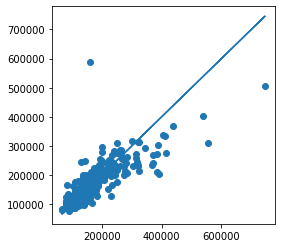

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.scatter(np.exp(y_test*(y_max - y_min) + y_min), np.exp(y_pred*(y_max - y_min) + y_min), label='predicted');
axes.plot(np.exp(y_test*(y_max - y_min) + y_min), np.exp(y_test*(y_max - y_min) + y_min), label='actual');

In [9]:
model.evaluate(X_test, y_test, batch_size=batch_size)

292/292 [==============================] - 0s 188us/step


[0.0049242160421770625, 0.0049242160421770625]

## 【問題5】MNISTをKerasで学習

In [22]:
from keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#yをone-hot化
eye = np.eye(len(np.unique(y_train)))
y_train = eye[y_train]
y_test = eye[y_test]

In [23]:
#maxを1に変換
X_train = X_train / 255.0
X_test = X_test / 255.0

In [24]:
#reshape
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])

In [25]:
#split into train, val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape) 

(48000, 784)
(12000, 784)


In [26]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

# ハイパーパラメータの設定

batch_size = 1000
n_epochs = 20

n_input = X_train.shape[1]
n_hidden1 = 50
n_hidden2 = 100
n_classes = y_train.shape[1]

model = Sequential()
model.add(Dense(output_dim=n_hidden1, input_dim=n_input))
model.add(Activation('relu'))
model.add(Dense(output_dim=n_hidden2, input_dim=n_hidden1))
model.add(Activation('relu'))
model.add(Dense(output_dim=n_classes, input_dim=n_hidden2))
model.add(Activation('softmax'))

#compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#fit
model.fit(
        x=X_train, y=y_train,
        epochs=n_epochs, batch_size=batch_size,
        validation_data=(X_val, y_val)
)

/Users/ohmori/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=784, units=50)`
/Users/ohmori/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, units=100)`
/Users/ohmori/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=10)`


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 24us/step - loss: 1.1567 - acc: 0.7096 - val_loss: 0.4236 - val_acc: 0.8842
Epoch 2/20
48000/48000 [==============================] - 1s 15us/step - loss: 0.3457 - acc: 0.9023 - val_loss: 0.2886 - val_acc: 0.9209
Epoch 3/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.2640 - acc: 0.9252 - val_loss: 0.2389 - val_acc: 0.9362
Epoch 4/20
48000/48000 [==============================] - 1s 17us/step - loss: 0.2255 - acc: 0.9354 - val_loss: 0.2159 - val_acc: 0.9408
Epoch 5/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.2007 - acc: 0.9424 - val_loss: 0.2023 - val_acc: 0.9450
Epoch 6/20
48000/48000 [==============================] - 1s 15us/step - loss: 0.1802 - acc: 0.9483 - val_loss: 0.1786 - val_acc: 0.9515
Epoch 7/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.1641 - acc: 0.9530 - val_loss: 0.1681 - val_acc

In [28]:
y_pred = model.predict(X_test,  batch_size=batch_size)
judge = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)
accuracy = judge.sum()/len(y_pred)
print(judge)
print(accuracy)

[ True  True  True ...  True  True  True]
0.9682


## 【問題6】（アドバンス課題）PyTorchへの書き換え

MNISTでやってみる

In [5]:
import torch

## 【問題7】（アドバンス課題）フレームワークの比較
それぞれのフレームワークにはどのような違いがあるかをまとめてください。

興味がある場合はTensorFlow、Keras、PyTorch以外にも触れてみましょう。

視点例

計算速度
コードの行数・可読性
用意されている機能
